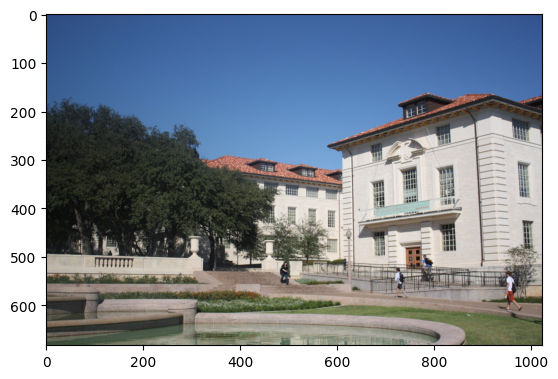

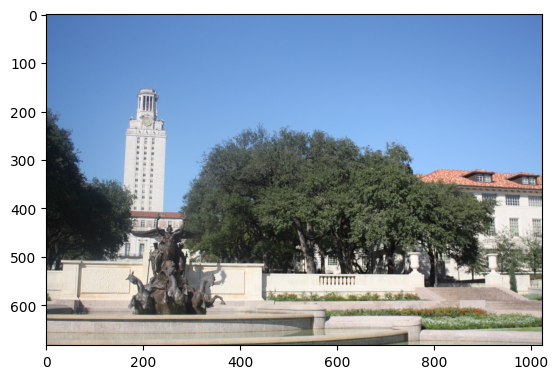

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


# load image on from images/1.png and images/2.png rgb

img1 = cv2.imread('images/1.jpg')
img2 = cv2.imread('images/2.jpg')
# make them rgb
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# show image using matplotlib
plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()


In [27]:
window_name = 'Image Correspondences'
correspondences = []

# Mouse callback function
def mouse_callback(event, x, y, flags, param):
    global correspondences
    if event == cv2.EVENT_LBUTTONDOWN:
        correspondences.append((x, y))
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow(window_name, img)
        print(f"Point selected: ({x}, {y})")


# Display the images
cv2.imshow(window_name, img1)
img = img1.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points1 = np.array(correspondences)
correspondences = []

cv2.imshow(window_name, img2)
img = img2.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points2 = np.array(correspondences)

cv2.destroyAllWindows()

print(points1)
print(points2)    

Point selected: (317, 465)
Point selected: (324, 507)
Point selected: (180, 507)
Point selected: (102, 505)
Point selected: (769, 500)
Point selected: (781, 539)
Point selected: (636, 543)
Point selected: (567, 542)
[[317 465]
 [324 507]
 [180 507]
 [102 505]]
[[769 500]
 [781 539]
 [636 543]
 [567 542]]
